In [98]:
from landlab.components import AnalysisManager, ChannelProfiler,  FlowAccumulator
from landlab import RasterModelGrid
from landlab.plot import imshow_grid
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PatchCollection
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
# import cv2
from typing import Tuple, Union, List
from collections import OrderedDict
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import os
from tqdm import tqdm
import multiprocessing

# クラス定義

In [3]:
from landlab.components import AnalysisManager, ChannelProfiler,  FlowAccumulator
from landlab import RasterModelGrid
from landlab.plot import imshow_grid
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PatchCollection
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
# import cv2
from typing import Tuple, Union, List
from collections import OrderedDict
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import os
from tqdm import tqdm
import multiprocessing

class ChannelExtractor(AnalysisManager):

    """
    本流路のマスクを作成し、そのマスクを用いて画像を作成する。背景となる変数は、S_s, da, zのいずれかを指定する。
    """    

    def __init__(self, dirpath: str, HDF_fname: str, output_dir: str, 
                 background_vname: str="S_s", min_value_for_normalization: float=None,
                 max_value_for_normalization: float=None, Yrs: List[int]=None,
                 cols_from_outlet: int=40, rows_from_outlet: int=90,
                 cmap="binary"):

        """
        Parameters
        ----------
        dirpath : str
            データのあるディレクトリのパス
        HDF_fname : str
            データのあるHDFファイル名
        output_dir : str
            画像を保存するディレクトリのパス
        background_vname : str, optional
            背景となる変数名{S_s, da, z}. The default is "S_s".
        min_value_for_normalization : float, optional
            背景となる変数の最小値. The default is None.
        max_value_for_normalization : float, optional
            背景となる変数の最大値. The default is None.
        Yrs : List[int], optional
            画像を作成する年度のリスト. The default is None.
        cols_from_outlet : int, optional
            河口ノードから左右に抽出する列数. The default is 40.
        rows_from_outlet : int, optional
            河口ノードから上流側に抽出する行数. The default is 90.
        """        

        super().__init__(dirpath, HDF_fname)

        self.output_dir = output_dir
        self.background_vname = background_vname # 背景となる変数名{S_s, da, z}
        self.min_value_for_normalization = min_value_for_normalization # 背景となる変数の最小値
        self.max_value_for_normalization = max_value_for_normalization # 背景となる変数の最大値
        self.Yrs = Yrs # 画像を作成する年度のリスト
        self.cols_from_outlet = cols_from_outlet # 河口ノードから左右に抽出する列数
        self.rows_from_outlet = rows_from_outlet
        self.cmap = plt.cm.get_cmap(cmap)

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def initialize_at_readYr(self, read_Yr: int, main_channel_only: bool=True,
                             mg: RasterModelGrid=None, fa: FlowAccumulator=None,
                             prf: ChannelProfiler=None):
                             

        """
        read_Yrで指定した年度のデータを読み込み、以下の初期化を行う. 引数にmg, fa, prfを指定した場合は、それらを用いて初期化を行う。
        ただし、それらのmg, prfはfa.run_one_step(), prf.run_one_step()を実行した後のものである必要がある。

        1. RasterModelGrid, FlowAccumulator, topographic__elevation, ChannelProfilerを作成する。
        2. ChannelProfiler.run_one_step()を実行し、本流路の情報を取得する。

        Parameters
        ----------
        read_Yr : int
            読み込む年度
        main_channel_only : bool, optional
            本流路のみを取得するかどうか. The default is True.
            prfオブジェクトが指定されている場合は、prfオブジェクトの設定に従う。
        mg : RasterModelGrid, optional  
            RasterModelGrid. The default is None.
        fa : FlowAccumulator, optional
            FlowAccumulator. The default is None.
        prf : ChannelProfiler, optional
            ChannelProfiler. The default is None.
        """        

        self.read_Yr = read_Yr

        if (mg is None) or (fa is None) or (prf is None):
            self.mg = self.create_mg(Yr=self.read_Yr) 
            self.fa = self.create_fa(mg=self.mg)
            self.fa.run_one_step()
            thresh_da = self.Latero_dict["thresh_da"]
            self.prf = ChannelProfiler(self.mg, number_of_watersheds=1, 
                                       main_channel_only=main_channel_only, 
                                       minimum_channel_threshold=thresh_da)
            self.prf.run_one_step()
        else:
            self.mg = mg
            self.fa = fa
            self.prf = prf

        self.z = self.mg.at_node['topographic__elevation']
        self.da = self.mg.at_node['drainage_area']
        self.S_s = self.mg.at_node['topographic__steepest_slope']
        self.ncols, self.nrows = self.mg.shape
        self.flow_node_ids = self.prf._nodes[0]

        self.xarr_map = self.mg.x_of_node # 領域全体のx座標の1次元配列
        self.yarr_map = self.mg.y_of_node # 領域全体のy座標の1次元配列
        self.xarr_flow = self.mg.x_of_node[self.flow_node_ids] # 本流路のx座標の1次元配列. 下流から上流に向かって並んでいる
        self.yarr_flow = self.mg.y_of_node[self.flow_node_ids] # 本流路のy座標の1次元配列. 下流から上流に向かって並んでいる

        self.map_edge_ids = self.mg.boundary_nodes # 領域全体の境界のノードIDの1次元配列

        self.outlet_id = self.prf._outlet_nodes[0] # 流出点のノードID
        self.outlet_x = self.mg.x_of_node[self.outlet_id] # 流出点のx座標
        self.outlet_y = self.mg.y_of_node[self.outlet_id] # 流出点のy座標
        self.outlet_col = np.where(self.mg.node_x == self.outlet_x)[0][0] # 流出点の列番号
        self.outlet_row = np.where(self.mg.node_y == self.outlet_y)[0][0] # 流出点の行番号

        
    def create_channel_mask(self) -> np.ndarray:

        """
        本流路のマスクを作成する。

        Returns
        -------
        channel_mask : np.ndarray
            本流路のマスク
        """

        channel_mask = np.zeros(self.z.shape, dtype=bool)
        channel_mask[self.flow_node_ids] = True

        if "channel_mask" not in self.mg.at_node:
            self.mg.add_ones("channel_mask", at="node", dtype=bool)

        self.mg.at_node["channel_mask"] = channel_mask

        return channel_mask    
    
    def create_masked_elevation_map(self, mask: np.ndarray, field_name: str="masked_elevation") -> np.ndarray:
            
        """
        任意のマスクを用いて、標高マップをマスクする。

        Parameters
        ----------
        mask : np.ndarray
            任意のマスク

        Returns
        -------
        masked_elevation_map : np.ndarray
            マスクされた標高マップ
        """

        zmin = np.min(self.z)
        masked_elevation_map = np.where(mask, self.z, zmin)

        if field_name not in self.mg.at_node:
            self.mg.add_zeros(field_name, at="node", dtype=float)

        self.mg.at_node[field_name] = masked_elevation_map

        return masked_elevation_map
    
    def create_gradient_image(self, mask: np.ndarray, value: np.ndarray, 
                              min_value: float, max_value: float, cmap: plt.cm) -> np.ndarray:

        """
        任意のマスクを用いて、標高マップをマスクする。その際、標高値を正規化し、グラデーションカラーマップを用いてRGB値に変換する。

        Returns
        -------
        output_img : np.ndarray
            マスクされた標高マップ
        """        

        # マスクから本流セルの標高値を抽出
        mainstream_value = value[mask==1]
        
        # 標高値を正規化
        if min_value is None:
            min_value = np.min(mainstream_value)
        if max_value is None:
            max_value = np.max(mainstream_value)

        mainstream_value = np.clip(mainstream_value, min_value, max_value)

        normalized_value = (mainstream_value - min_value) / (max_value - min_value)
    
        # グラデーションカラーマップからRGB値を取得
        rgb = cmap(normalized_value)

        # rgbは(n, 4)の配列になっているので、4の内訳はRGBAの順
        # 今回はAは使わないので、Aの代わりにもとのもとの標高値を入れておく
        # rgb[:, 3] = mainstream_value
        
        # 出力画像を用意   
        h, w = self.nrows, self.ncols
        output_img = np.zeros((h, w, 4))
        
        # マスクを使って本流セルにRGB値を書き込み
        mask_2d = np.reshape(mask, (h, w))
        output_img[mask_2d==1, :] = rgb
        
        return output_img
    
    def extract_downstream_area(self, value_array: np.ndarray, 
                                cols_from_outlet: int, rows_from_outlet: int) -> np.ndarray:

        """
        河口から指定した行数、列数だけ下流エリアをvalue_arrayから抽出する。
        そのとき、列方向には河口ノードを中心として左右にcols_from_outletだけ抽出する。
        行方向には河口ノードを中心として上流側にrows_from_outletだけ抽出する。

        河口がy=0, 上流がy=ncolsの方向にあるとする。

        Parameters
        ----------
        value_array : np.ndarray
            抽出元の配列
        cols_from_outlet : int
            河口ノードから左右に抽出する列数
        rows_from_outlet : int
            河口ノードから上流側に抽出する行数

        Returns
        -------
        downstream_area : np.ndarray
            河口から指定した行数、列数だけ下流エリアを抽出した配列
        """         
        # 河口ノードの列番号
        outlet_col = self.outlet_col
        # 河口ノードの行番号
        outlet_row = self.outlet_row

        # 河口ノードからcols_from_outletだけ左右に抽出する
        left_col = outlet_col - cols_from_outlet
        right_col = outlet_col + cols_from_outlet
        # 河口ノードからrows_from_outletだけ上流側に抽出する
        upstream_row = rows_from_outlet - outlet_row

        # 河口ノードから指定した行数、列数だけ下流エリアを抽出する
        if value_array.ndim == 2:
            downstream_area = value_array[:upstream_row, left_col:right_col]
        elif value_array.ndim == 3:
            downstream_area = value_array[:upstream_row, left_col:right_col, :]

        return downstream_area
    
    def make_image(self, image_array: np.ndarray, show_image: bool=True, 
                   save_image: bool=True) -> None:

        """
        引数のimage_arrayをもとに画像を作成する。そのとき、画像左下に年代を表示する。
        また、軸は非表示にする。

        Parameters
        ----------
        image_array : np.ndarray
            画像のもととなる配列
        show_image : bool, optional
            画像を表示するかどうか. The default is True.
        save_image : bool, optional
            画像を保存するかどうか. The default is True.
        """        

        image_row, image_col = image_array.shape[:2]
        fig_hegiht = 7
        fig_width = fig_hegiht * image_col / image_row
        fig, ax = plt.subplots(figsize=(fig_width, fig_hegiht), tight_layout=True)
        ax.imshow(np.flipud(image_array))
        ax.axis("off")
        fig.text(0, 0, f"{self.read_Yr}yr", fontsize=20)

        if save_image:
            # dpi = max(image_row, image_col)
            fig.savefig(f"{self.output_dir}/{self.read_Yr}yr.png")

        if show_image:
            plt.show()
        else:
            plt.clf()
            plt.close()

    def make_channel_masked_image(self):

        """
        指定した年度のデータを読み込み、
        本流路のマスクを作成し、そのマスクを用いて画像を作成する。
        """        
        total_iter = len(self.Yrs)
        processin_bar = np.arange(total_iter)

        for i in tqdm(processin_bar):

            Yr = self.Yrs[i]

        # for Yr in self.Yrs:

            self.initialize_at_readYr(Yr)
            channel_mask = self.create_channel_mask()
            channel_mask = self.create_channel_mask()
            
            # マスクの背景変数を取得
            if self.background_vname == "S_s":
                value = self.S_s
            elif self.background_vname == "da":
                value = self.da
            elif self.background_vname == "z":
                value = self.z
            else:
                raise ValueError("background_vname must be one of S_s, da, z.")

            min_value = self.min_value_for_normalization
            max_value = self.max_value_for_normalization

            output_img = self.create_gradient_image(mask=channel_mask, 
                                                    value=value, 
                                                    min_value=min_value, 
                                                    max_value=max_value, 
                                                    cmap=self.cmap)

            dwonstream_area = self.extract_downstream_area(value_array=output_img, 
                                                           cols_from_outlet=self.cols_from_outlet, 
                                                           rows_from_outlet=self.rows_from_outlet)
            
            self.make_image(image_array=dwonstream_area, show_image=False, save_image=True)



class ChannelImageMaker:

    """
    ChannelImageMaker
    -----------------
    ChannelExtractorオブジェクトを複数作成し、それぞれのオブジェクトを用いて並列処理で画像を作成する。
    """    

    
    def __init__(self, ParamList):

        """
        Parameters
        ----------
        ParamList : List[OrderedDict]
            それぞれ異なる計算条件でのHDFファイルから画像を作成するためのパラメータのリスト。
            これらのパラメータをもとに、ChannelExtractorクラスのインスタンスを作成する。
        """        

        self.processingNum = len(ParamList)
        self.instanceList = [] # それぞれ異なる計算条件でのLataralSimilateManagerクラスのインスタンスを要素にもつ
        for pm in ParamList:
            self.instanceList.append(ChannelExtractor(**pm))

                           
    def make_images(self):
        # p = multiprocessing.Pool(self.processingNum)
        # print("making image......................")
        # p.map(self._make_image, self.instanceList)
        # print("--------Finish--------------------")

        for i in range(self.processingNum):
            print(f"making image {i+1}/{self.processingNum}")
            self._make_image(self.instanceList[i])
        
    def _make_image(self, chex_obj: ChannelExtractor):
        return chex_obj.make_channel_masked_image()


In [70]:
chex.Dataset_Pointer

40

In [ ]:
cim

# ChannelExtractor

##  インスタンス化

In [31]:
dirpath = r"Z:\miyata\landlab_exp\width_analysis\simulation result\sample"
HDF_name = r"solver_ffwindow_C_ver2_ncols_150_150.h5"

chex = ChannelExtractor(dirpath, HDF_name)

Yr = 500000

chex.initialize_at_readYr(Yr)

In [34]:
chex.prf._data_struct[chex.outlet_id]

{(75,
  22035): {'ids': array([   75,   226,   377,   228,   379,   529,   680,   831,   682,
           533,   384,   385,   386,   537,   538,   689,   840,   990,
          1139,  1288,  1287,  1437,  1586,  1735,  1885,  2036,  2187,
          2338,  2339,  2190,  2039,  1890,  1741,  1742,  1893,  2044,
          2195,  2344,  2343,  2342,  2492,  2642,  2641,  2790,  2939,
          3089,  3240,  3391,  3540,  3689,  3839,  3990,  4141,  4291,
          4440,  4590,  4741,  4892,  4893,  4894,  4895,  4746,  4897,
          5048,  5197,  5346,  5345,  5494,  5644,  5795,  5945,  6096,
          6097,  6248,  6249,  6100,  5950,  5799,  5649,  5500,  5501,
          5502,  5653,  5804,  5955,  6105,  6255,  6404,  6554,  6703,
          6852,  6701,  6850,  7000,  7150,  7300,  7301,  7452,  7453,
          7304,  7305,  7306,  7157,  7308,  7459,  7608,  7757,  7906,
          8055,  8204,  8353,  8503,  8654,  8805,  8955,  9104,  9253,
          9404,  9555,  9706,  9856, 10005

In [23]:
chex.prf._outlet_nodes

array([75])

In [25]:
mg = chex.mg
mg.node_x, mg.node_y

(array([     0.,    100.,    200., ...,  14700.,  14800.,  14900.]),
 array([     0.,      0.,      0., ...,  14900.,  14900.,  14900.]))

In [35]:
print("outlet_x: ", chex.outlet_x)
print("outlet_col: ", chex.outlet_col)
print("check: ", mg.node_x[chex.outlet_col])

print("outlet_y: ", chex.outlet_y)
print("outlet_row: ", chex.outlet_row)
print("check: ", mg.node_y[chex.outlet_row])

outlet_x:  7500.0
outlet_col:  75
check:  7500.0
outlet_y:  0.0
outlet_row:  0
check:  0.0


### 関数テスト

#### create_channel_mask

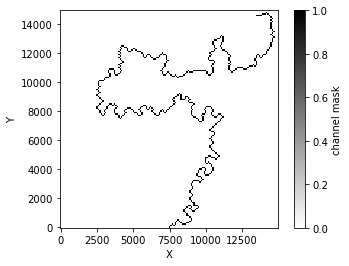

In [5]:
channel_mask = chex.create_channel_mask()

imshow_grid(chex.mg, "channel_mask", color_for_closed="none", cmap="binary", colorbar_label="channel mask")

#### create_masked_elevation_map

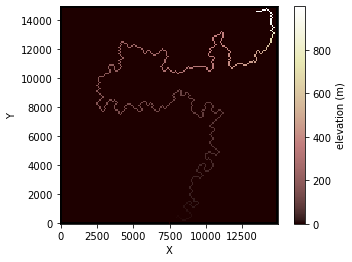

In [6]:
dirpath = r"Z:\miyata\landlab_exp\width_analysis\simulation result\sample"
HDF_name = r"solver_ffwindow_C_ver2_ncols_150_150.h5"

cim = ChannelImageMaker(dirpath, HDF_name)

Yr = 500000
chex.initialize_at_readYr(Yr)
channel_mask = chex.create_channel_mask()
masked_elevation_map = chex.create_masked_elevation_map(channel_mask)

imshow_grid(chex.mg, "masked_elevation", colorbar_label="elevation (m)")

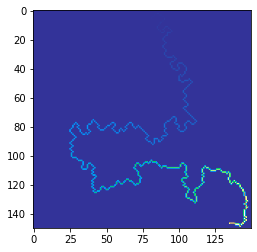

In [30]:
plt.imshow(masked_elevation_map.reshape(chex.nrows, chex.ncols), cmap="terrain")

<AxesSubplot:ylabel='Count'>

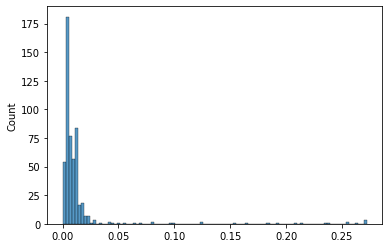

In [7]:
S_s = chex.S_s[chex.flow_node_ids]
sns.histplot(S_s, bins=100)

#### create_gradient_image

(-0.5, 149.5, 149.5, -0.5)

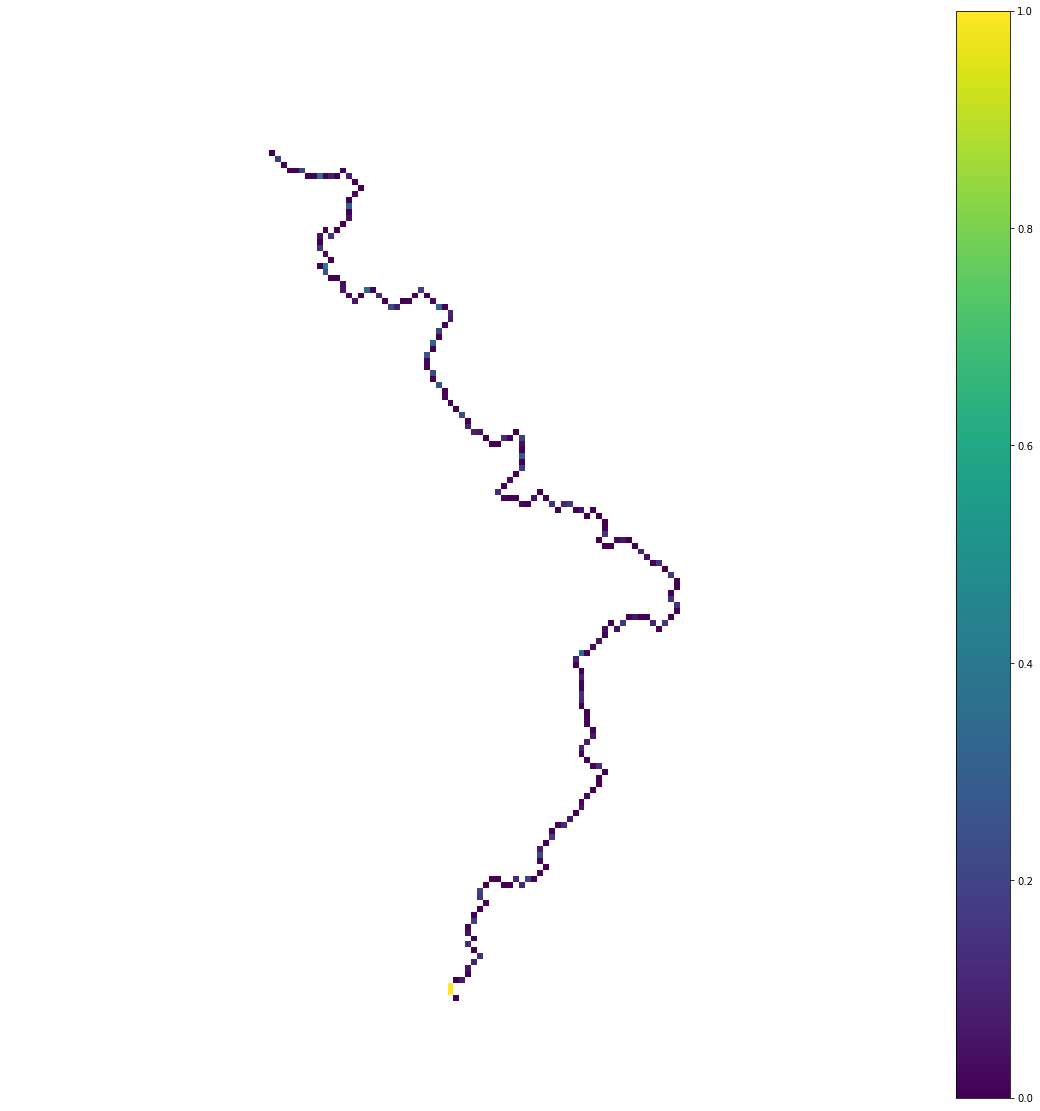

In [22]:
dirpath = r"Z:\miyata\landlab_exp\width_analysis\simulation result\sample"
HDF_name = r"solver_ffwindow_C_ver2_ncols_150_150.h5"

cim = ChannelImageMaker(dirpath, HDF_name)

Yr = 100
chex.initialize_at_readYr(Yr)
channel_mask = chex.create_channel_mask()

# cmap = plt.cm.get_cmap("rainbow")
# cmap = plt.cm.get_cmap("binary")
# cmap = plt.cm.get_cmap("terrain")
cmap = plt.cm.get_cmap("viridis")
# z = chex.z
# zmin = np.min(z)
# zmax = np.max(z)
S_s = chex.S_s
S_s_min = 0.0
S_s_max = 0.01
output_img = chex.create_gradient_image(mask=channel_mask, value=S_s, min_value=S_s_min, max_value=S_s_max, cmap=cmap)

plt.figure(figsize=(20, 20))
plt.imshow(np.flipud(output_img))
plt.colorbar()

# 軸目盛を消す
plt.axis("off")


In [37]:
output_img.shape

(150, 150, 4)

#### extract_downstream_area

(-0.5, 79.5, 89.5, -0.5)

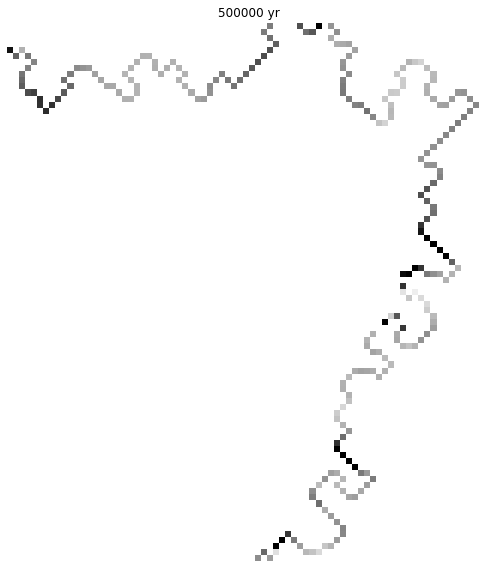

In [62]:
dirpath = r"Z:\miyata\landlab_exp\width_analysis\simulation result\sample"
HDF_name = r"solver_ffwindow_C_ver2_ncols_150_150.h5"

chex = ChannelExtractor(dirpath, HDF_name)

Yr = 500000

chex.initialize_at_readYr(Yr)
channel_mask = chex.create_channel_mask()

# cmap = plt.cm.get_cmap("viridis")
cmap = plt.cm.get_cmap("binary")
S_s = chex.S_s
S_s_min = 0.0
S_s_max = 0.01
output_img = chex.create_gradient_image(mask=channel_mask, value=S_s, min_value=S_s_min, max_value=S_s_max, cmap=cmap)

dwonstream_area = chex.extract_downstream_area(value_array=output_img, cols_from_outlet=40, rows_from_outlet=90)

plt.figure(figsize=(10, 10))
plt.imshow(np.flipud(dwonstream_area))
plt.title(f"{Yr} yr")
# plt.colorbar()

# 軸目盛を消す
plt.axis("off")


#### make_image

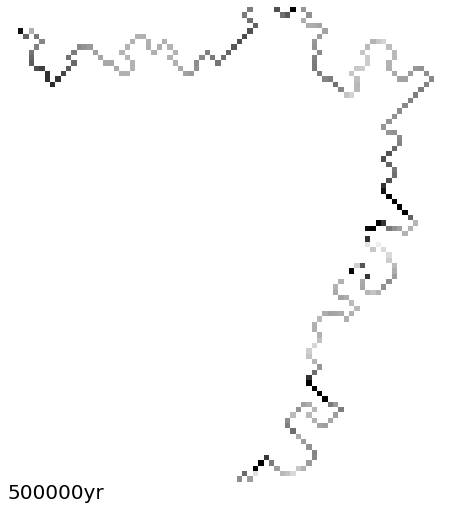

In [77]:
dirpath = r"Z:\miyata\landlab_exp\width_analysis\simulation result\sample"
HDF_name = r"solver_ffwindow_C_ver2_ncols_150_150.h5"
out_dirpath = r"Z:\miyata\RiverShapeRecognition_exp\test\output"

chex = ChannelExtractor(dirpath, HDF_name, out_dirpath)

Yr = 500000

chex.initialize_at_readYr(Yr)
channel_mask = chex.create_channel_mask()

# cmap = plt.cm.get_cmap("viridis")
cmap = plt.cm.get_cmap("binary")
S_s = chex.S_s
S_s_min = 0.0
S_s_max = 0.01
output_img = chex.create_gradient_image(mask=channel_mask, value=S_s, min_value=S_s_min, max_value=S_s_max, cmap=cmap)

dwonstream_area = chex.extract_downstream_area(value_array=output_img, cols_from_outlet=40, rows_from_outlet=90)

chex.make_image(image_array=dwonstream_area, show_image=True, save_image=True)


In [78]:
import os
from PIL import Image
import numpy as np

def read_image(img_path):

  # 画像ファイルが存在するか確認
  if not os.path.exists(img_path):
    print(f"File not found: {img_path}")
    return None

  # 画像ファイルをPILで開く
  img = Image.open(img_path)

  # NumPy配列に変換 
  img_array = np.asarray(img)

  return img_array

In [79]:
img_dir = r"Z:\miyata\RiverShapeRecognition_exp\test\output"
img_fname = "500000yr.png"
img_path = os.path.join(img_dir, img_fname)

img_array = read_image(img_path)

In [80]:
img_array.shape

(504, 448, 4)

(-0.5, 447.5, 503.5, -0.5)

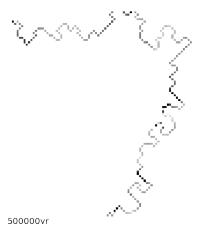

In [83]:
plt.imshow(img_array)
plt.axis("off")

#### make_channel_masked_image

In [97]:
dirpath = r"Z:\miyata\landlab_exp\width_analysis\simulation result\sample"
HDF_name = r"solver_ffwindow_C_ver2_ncols_150_150.h5"
out_dirpath = r"Z:\miyata\RiverShapeRecognition_exp\test\output"

extractor_kwargs = {"dirpath": r"Z:\miyata\landlab_exp\width_analysis\simulation result\sample",
                    "HDF_fname": r"solver_basic_ncols_150_150.h5",
                    "output_dir": r"Z:\miyata\RiverShapeRecognition_exp\test\output\Langston",
                    "background_vname": "S_s", 
                    "min_value_for_normalization": 0.0, 
                    "max_value_for_normalization": 0.01, 
                    "Yrs": np.arange(100, 100000, 10000),
                    "cols_from_outlet": 40, 
                    "rows_from_outlet": 90,
                    "cmap": "viridis"}

chex = ChannelExtractor(**extractor_kwargs)

chex.make_channel_masked_image()


# ChannelImageMaker

In [6]:
dirpath_list = [
    r"F:\miyata\landlab exp\solver-nodefinder_test\langston_langston\runoff_2.5",
    r"F:\miyata\landlab exp\solver-nodefinder_test\ULE_ffwindow\runoff_2.5",
]

HDF_fname_list = [
    r"solver_langston_nodefinder_langston_runoff_2.5.h5",
    r"solver_ULE_nodefinder_ffwindow_runoff_2.5.h5",
]

out_dirpath_list = [
    r"F:\miyata\RiverShapeRecognition_exp\image\langston_langston\runoff_2.5",
    r"F:\miyata\RiverShapeRecognition_exp\image\ULE_ffwindow\runoff_2.5",
]


basic_kwargs = {"dirpath": r"Z:\miyata\landlab_exp\width_analysis\simulation result\sample",
                "HDF_fname": r"solver_basic_ncols_150_150.h5",
                "output_dir": r"Z:\miyata\RiverShapeRecognition_exp\test\output\Langston",
                "background_vname": "S_s", 
                "min_value_for_normalization": 0.0, 
                "max_value_for_normalization": 0.01, 
                "Yrs": np.arange(100000, 1500000, 1000),
                "cols_from_outlet": 40, 
                "rows_from_outlet": 90,
                "cmap": "viridis"}

ParamList = []

for dirpath, HDF_fname, out_dirpath in zip(dirpath_list, HDF_fname_list, out_dirpath_list):
    kwargs = basic_kwargs.copy()
    kwargs["dirpath"] = dirpath
    kwargs["HDF_fname"] = HDF_fname
    kwargs["output_dir"] = out_dirpath
    ParamList.append(kwargs)

cim = ChannelImageMaker(ParamList)
cim.make_images()

making image 1/2


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


making image 2/2


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


In [5]:
cim.instanceList[0].end_time

800000